In [2]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_O

In [4]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made

# my own file:
already_imported = 'gm' in globals()
try:
    import gradient_method as gm
except:
    try:
        import Bubble_dynamics_simulation.gradient_method as gm
    except:
        print(colored(f'Error, \'gradient_method.py\' not found', 'red'))
if already_imported: importlib.reload(gm)   # reload changes you made

to_optimize = 'energy_efficiency'   # key in data from de.get_data()

model: chem_Otomo2018_without_O
target specie: NH3
excitation: no_excitation (control parameters: [])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: False


In [12]:
"""Control parameter ranges"""
# Range or a single value for most control parameters
ranges = dict(
    # Equilibrium radius [um --> m]
    R_E = [1.0e-6*x for x in [1.0,900.0]], #[1.0, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0]],
    # R_star / R_E [-]
    ratio = [1.1,10.0], #[2.0, 3.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0],
    # Ambient pressure [Pa]
    P_amb = [1.01325e5*x for x in [1.0]],#[0.00, 0.50]], #[1e5*x for x in [1.0, 10.0, 25.0, 50.0]],
    # Accommodation coeff. for evaporation [-]
    alfa_M = [0.35],
    # Ambient temperature [°C --> K]
    T_inf = [273.15+x for x in [20.0]],
    # Surface tension modifier [-]
    surfactant = [1.0],#[0.0,1.0],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions = [[0.40, 0.60],[0.85, 0.15]], 
    #Exciting frequency 1 [Hz]
    freq1 = [2.0e4], 
    #Exciting frequency 2 [Hz]
    freq2 = [1.0e5], 
    #Exciting pressure amplitude 1 [Pa]
    pA1 = [0.0e5], 
    #Exciting pressure amplitude 2 [Pa]
    pA2 = [0.0e5], 
    #Initial phase angle between the exciting pressure waves [rad]
    theta_phase = [0.1],
    #Dynamic viscosity of the liquid [Pa*s]
    mu_L = [0.001 * x for x in [1.0]],#[0.1,100.0]],
    #Sound velocity in the liquid [m/s]
    c_L = [1483.0 * x for x  in [1.0]],#[0.0,2.0]], 
)

for key in gm.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

In [9]:
""" Gradient method, multithread"""

searches = 1    # number os total searches
best_output = 1.0e30
total_point_num = 0
num = 0
to_plot = []
to_scatter = []
last_points = []
start = time.time()
file = gm.de.Make_dir('test 1')

x = gm.rand_point(ranges, gases=[gm.de.par.index['H2'], gm.de.par.index['N2']])
x['R_E'] = 8.0e-6
x['ratio'] = 4.0

kwargs_list = [dict(
    ranges=ranges,
    to_optimize=to_optimize,
    start_point=x,#gm.rand_point(ranges, gases=[gm.de.par.index['H2'], gm.de.par.index['N2']]),
    max_steps=2000, #in gradient method
    first_step=0.05, #between two parameter combinations
    min_step=0.00001, #between two parameter combinations
    decay=0.6,
    learning_rate=1.0, #x_n+1=x_n-gamma*grad(F(x_n))
    t_int=np.array([0.0, 1.0]),
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for i in range(searches)]

with Pool(processes=cpu_count(), maxtasksperchild=10) as pool:
    results = pool.imap_unordered(gm.search, kwargs_list)
    for result in results:
        datas, best_central_values, elapsed, step_num, point_num = result
        total_point_num += point_num
        num += 1
        to_plot.append(best_central_values)
        to_scatter.append(gm.de.copy(datas[-1]))
        last_points.append(best_central_values[-1])
        for i in range(len(datas)):
            if datas[i]['output'] < best_output:
                best_output = datas[i]['output']

        # save points
        file.new_file()
        for data in datas:
            file.write_line(data)
        file.close()
        del(datas)
        
        # print stuff:
        if point_num==0: point_num=1
        print(f'{num}/{searches}: Total {step_num} steps and {point_num} points, finished in {elapsed: .2f} [s]   ({(elapsed / point_num): .2f} [s/run]).   '+
              f'Final {to_optimize} (central value): {best_central_values[-1]: .1f} (best: {best_output: .1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / total_point_num): .2f} [s/run])')

Folder already exists with 30 csv in it
1/1: Total 160 steps and 640 points, finished in  3020.94 [s]   ( 4.72 [s/run]).   Final energy_efficiency (central value):  16499.7 (best:  16499.7)


DONE
total time:  0 hours  50 mins
             3028.75 [s]   ( 4.73 [s/run])


In [10]:
num=0
for result in results:
    datas, best_central_values, elapsed, step_num, point_num = result
    total_point_num += point_num
    num += 1
    to_plot.append(best_central_values)
    last_points.append(best_central_values[-1])
    for i in range(len(datas)):
        if datas[i]['output'] < best_output:
            best_output = best_central_values[-1]

        # save points
        #file.new_file()
        #for data in datas:
        #    file.write_line(data)
        #file.close()
        
        # print stuff:
    print(f'{num}/{searches}: Total {step_num} steps and {point_num} points, finished in {elapsed: .2f} [s]   ({(elapsed / point_num): .2f} [s/run]).   '+
          f'Final {to_optimize} (central value): {best_central_values[-1]: .1f} (best: {best_output: .1f})')

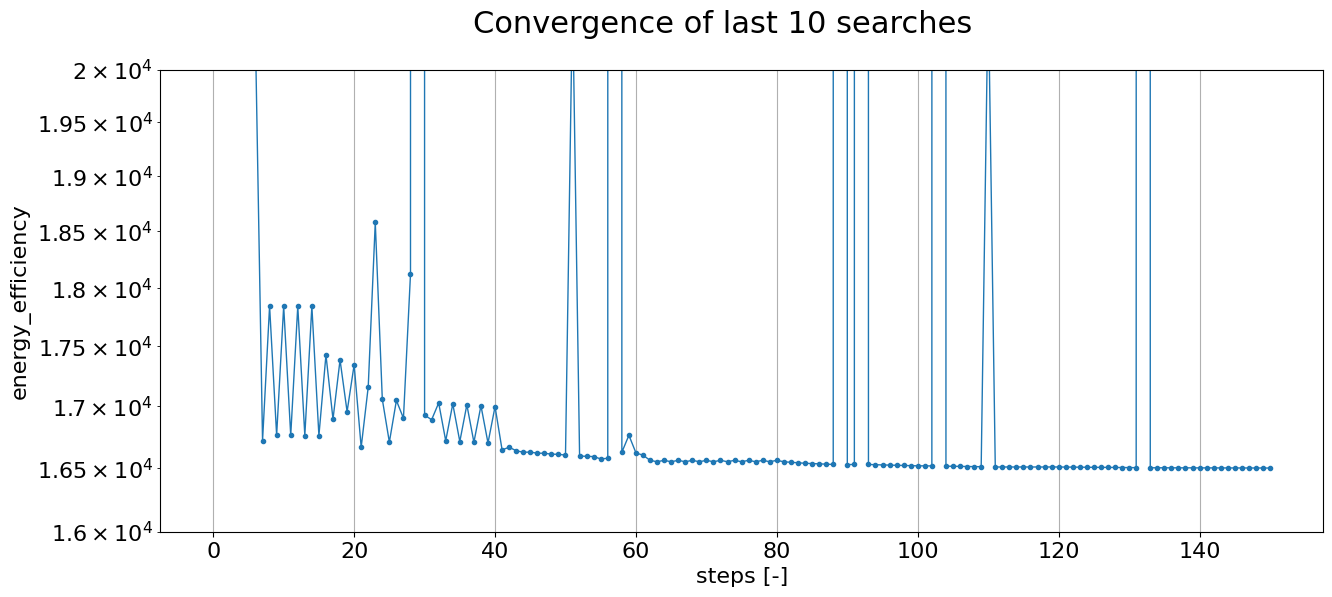

In [15]:
"""Plot convergence of last searches"""

plt.rcParams.update({'font.size': 16})
if len(to_plot) > 10:
    to_plot2 = to_plot[-10:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
ax.set_ylim(16000.0, 0.2e5)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

TypeError: 'float' object is not subscriptable

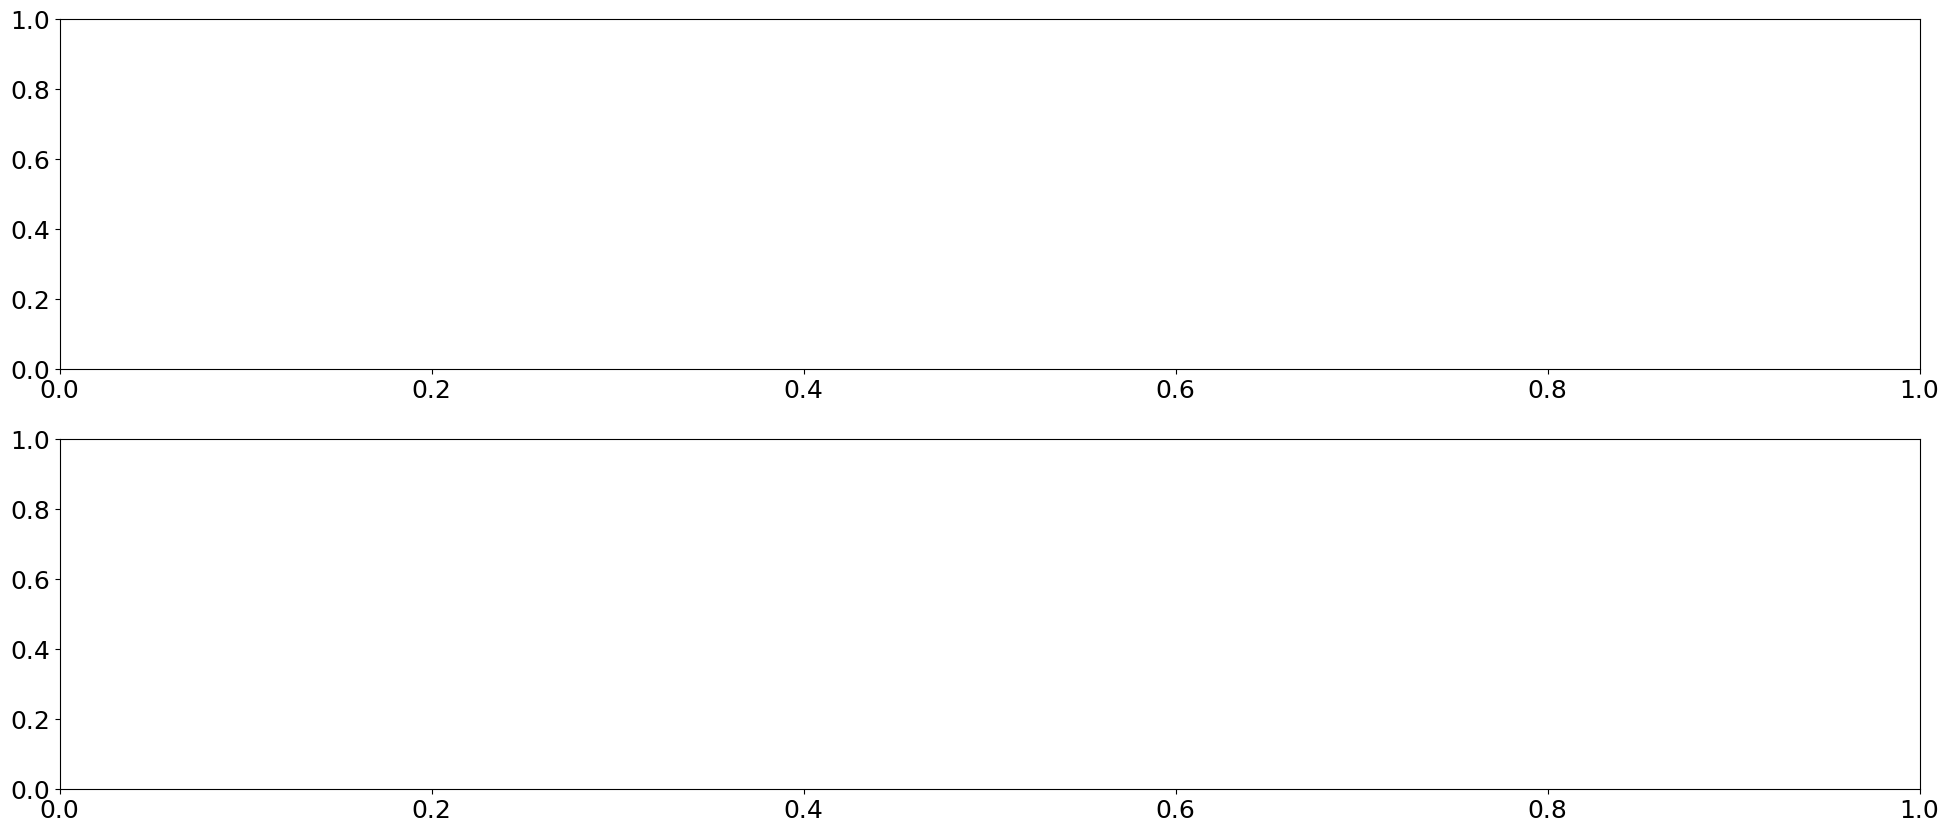

In [88]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 18})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=25, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.5*n, 1.5*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')